In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from shapely.geometry import Polygon

In [3]:
#to convert a geographic point into a circular buffer with radius in meters.

from shapely.geometry import Point
from functools import partial
from shapely.ops import transform
import pyproj

# def buffer_in_meters(lng, lat, radius):
def buffer_in_meters(pt_latlng, radius):
    proj_meters = pyproj.Proj(init='epsg:3857')
    proj_latlng = pyproj.Proj(init='epsg:4326')
    
    project_to_meters = partial(pyproj.transform, proj_latlng, proj_meters)
    project_to_latlng = partial(pyproj.transform, proj_meters, proj_latlng)
    
#     pt_latlng = Point(lng, lat)
    pt_meters = transform(project_to_meters, pt_latlng)
    
    buffer_meters = pt_meters.buffer(radius)
    buffer_latlng = transform(project_to_latlng, buffer_meters)
    return buffer_latlng

In [4]:
gdf_county = gpd.read_file("county.zip")

<AxesSubplot:>

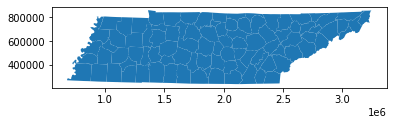

In [5]:
gdf_county.plot()

In [6]:
gdf_dav = gdf_county[gdf_county["COUNTY"] == "Davidson"]

In [7]:
gdf_dav.head()

,AREA,PERIMETER,TNCODD_,TNCODD_ID,INDEX_NO,COUNTY,STATE,geometry
30,0.136355,2.063989,32,30,63,Davidson,TN,"POLYGON ((1725320.674 734952.517, 1725410.826 ..."
49,0.000005,0.010867,51,99,63,Davidson,TN,"POLYGON ((1814456.873 657102.349, 1813945.726 ..."


In [9]:
gdf_david = gdf_dav.to_crs("EPSG:4326")
gdf_david.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [10]:
xmin, ymin, xmax, ymax = gdf_dav.total_bounds
gdf_dav.total_bounds

array([1656664.95403244,  595562.71399883, 1816136.87059501,
        755249.86127501])

In [12]:
length = 5280
wide = 5280

cols = list(np.arange(xmin, xmax + wide, wide))
print(len(cols))
rows = list(np.arange(ymin, ymax + length, length))
print(len(cols))

polygons = []
for x in cols[:-1]:
    for y in rows[:-1]:
        polygons.append(Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)]))

grid = gpd.GeoDataFrame({'geometry':polygons})
grid.to_file("grid.shp")
# grid.plot()

32
32


<AxesSubplot:>

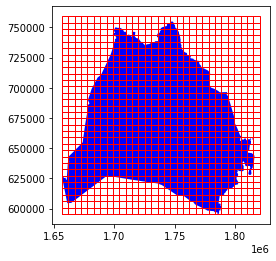

In [13]:
grid.plot(ax = gdf_dav.plot(color='blue'), color='none', edgecolor='red')

In [102]:
df_incidents = pd.read_json("incident.json")
gdf_incidents2 = gpd.GeoDataFrame(
    df_incidents, geometry=gpd.points_from_xy(df_incidents.longitude, df_incidents.latitude))
incidents = gdf_incidents2.set_crs("EPSG:4326")
incidents.head()

,ID_Original,latitude,longitude,emdCardNumber,time_utc,fireZone,time,time_local,response_time_sec,year,month,day,day_of_week,weekend_or_not,hour,window,geometry,Incident_ID,Dist_to_Seg,XDSegID
0,ObjectId(59d3a81908f47311c891f8e2),36.037228,-86.783243,29B5,1483257569507,10,1483257569507,1483235969507,268.0,2017,1,1,6,1,1,23,POINT (-86.78324 36.03723),10,13.550370,1.524394e+09
1,ObjectId(59d3a81908f47311c891f8e6),36.037414,-86.786572,29D2P,1483259455000,10,1483259455000,1483237855000,512.0,2017,1,1,6,1,2,30,POINT (-86.78657 36.03741),11,3.663952,1.524356e+09
2,ObjectId(59d3a81a08f47311c891f8ef),36.217663,-86.808699,29D1H,1483263310000,25,1483263310000,1483241710000,271.0,2017,1,1,6,1,3,43,POINT (-86.80870 36.21766),12,NaN,NaN
3,ObjectId(59d3a81a08f47311c891f8f9),36.057790,-86.739728,29D8V,1483266571867,10,1483266571867,1483244971867,366.0,2017,1,1,6,1,4,53,POINT (-86.73973 36.05779),13,NaN,NaN
4,ObjectId(59d3a81a08f47311c891f904),36.039221,-86.602785,29A2V,1483268953000,33,1483268953000,1483247353000,447.0,2017,1,1,6,1,5,61,POINT (-86.60279 36.03922),14,3.171782,4.496208e+08


In [272]:
# dav_grids = gpd.overlay(gdf_dav, grid, how='intersection')
# dav_grids.plot()

In [19]:
grids = grid.set_crs("EPSG:2274")
grids.crs

<Projected CRS: EPSG:2274>
Name: NAD83 / Tennessee (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - Tennessee - counties of Anderson; Bedford; Benton; Bledsoe; Blount; Bradley; Campbell; Cannon; Carroll; Carter; Cheatham; Chester; Claiborne; Clay; Cocke; Coffee; Crockett; Cumberland; Davidson; De Kalb; Decatur; Dickson; Dyer; Fayette; Fentress; Franklin; Gibson; Giles; Grainger; Greene; Grundy; Hamblen; Hamilton; Hancock; Hardeman; Hardin; Hawkins; Haywood; Henderson; Henry; Hickman; Houston; Humphreys; Jackson; Jefferson; Johnson; Knox; Lake; Lauderdale; Lawrence; Lewis; Lincoln; Loudon; Macon; Madison; Marion; Marshall; Maury; McMinn; McNairy; Meigs; Monroe; Montgomery; Moore; Morgan; Obion; Overton; Perry; Pickett; Polk; Putnam; Rhea; Roane; Robertson; Rutherford; Scott; Sequatchie; Sevier; Shelby; Smith; Stewart; Sullivan; Sumner; Tipton; Trousdale; Unicoi; Union; Van Buren; Warren; Wa

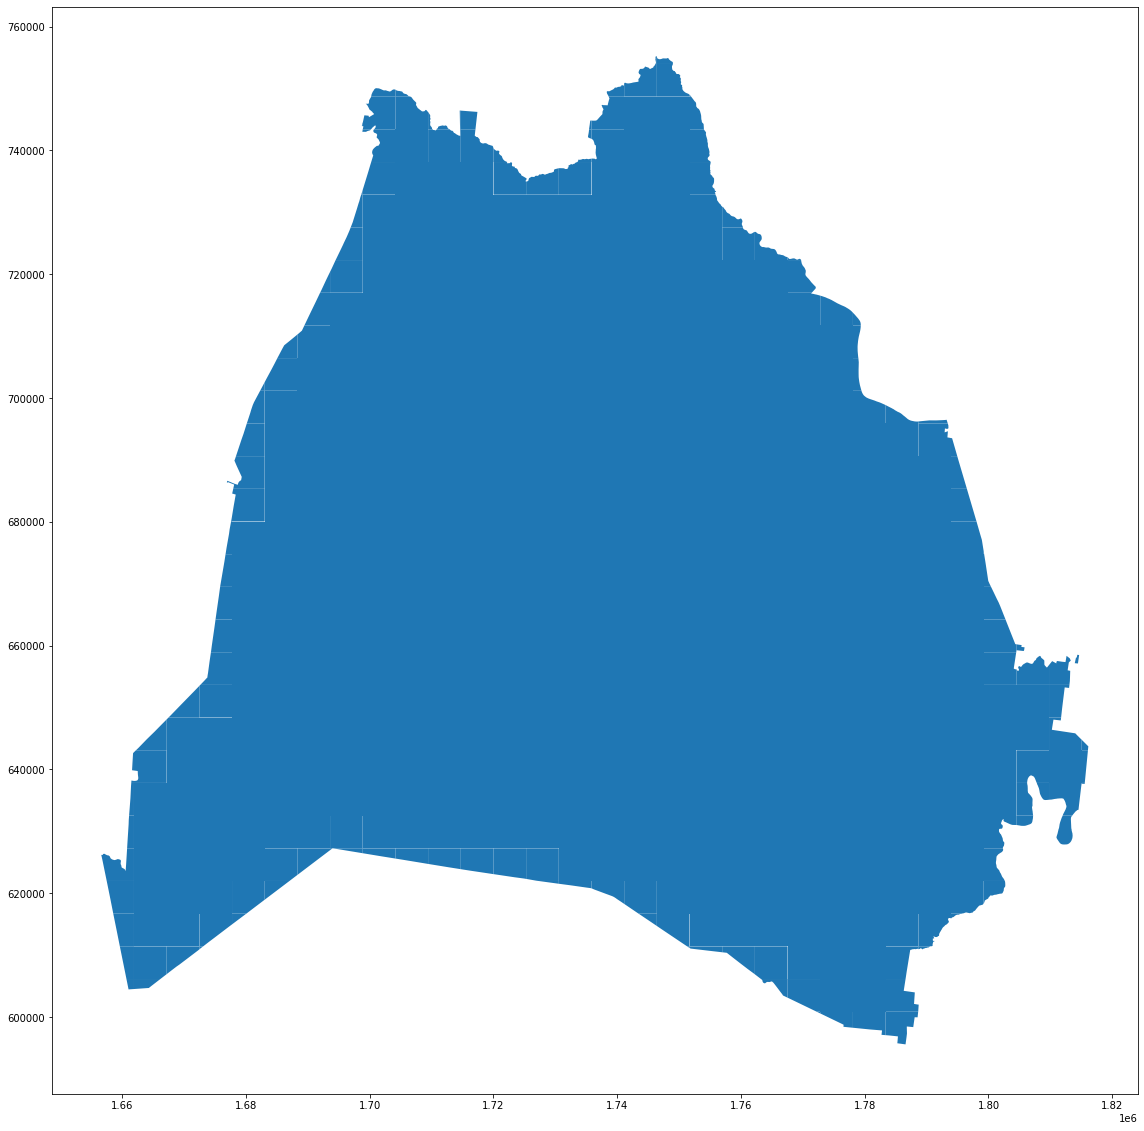

(604, 8)

In [20]:
dav_grids = gpd.overlay(gdf_dav, grids, how='intersection')
dav_grids.plot(figsize=(20, 20))
plt.show()
dav_grids.shape

In [21]:
dav_grids['row_num'] = np.arange(len(dav_grids))

In [25]:
dav_grids2 = dav_grids.to_crs("EPSG:4326")

<AxesSubplot:>

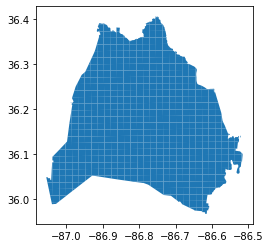

In [26]:
dav_grids2.plot()

In [27]:
dav_grids2

,AREA,PERIMETER,TNCODD_,TNCODD_ID,INDEX_NO,COUNTY,STATE,geometry,row_num
0,0.136355,2.063989,32,30,63,Davidson,TN,"POLYGON ((-87.03922 35.98939, -87.04042 35.993...",0
1,0.136355,2.063989,32,30,63,Davidson,TN,"POLYGON ((-87.04103 35.99633, -87.04244 36.001...",1
2,0.136355,2.063989,32,30,63,Davidson,TN,"POLYGON ((-87.04592 36.01500, -87.04780 36.022...",2
3,0.136355,2.063989,32,30,63,Davidson,TN,"POLYGON ((-87.04958 36.02909, -87.05145 36.036...",3
4,0.136355,2.063989,32,30,63,Davidson,TN,"POLYGON ((-87.05207 36.03851, -87.05333 36.043...",4
...,...,...,...,...,...,...,...,...,...
599,0.136355,2.063989,32,30,63,Davidson,TN,"POLYGON ((-86.53578 36.13838, -86.53350 36.137...",599
600,0.000005,0.010867,51,99,63,Davidson,TN,"POLYGON ((-86.52341 36.13752, -86.52274 36.140...",600
601,0.136355,2.063989,32,30,63,Davidson,TN,"POLYGON ((-86.51764 36.08397, -86.51927 36.084...",601
602,0.136355,2.063989,32,30,63,Davidson,TN,"POLYGON ((-86.51678 36.09155, -86.51759 36.084...",602


In [85]:
joined2 = incidents.sjoin(dav_grids2, how="right")

In [29]:
joined2['row_num'].nunique()

604

In [204]:
incidents.time_local[8]

1483255752000

In [195]:
from datetime import datetime

timestamp = 1483250400.000
#1483247353.000
#1483241710.000
#1483237855.000
#1483235969.507
# 1492677023.000
dt_object = datetime.fromtimestamp(timestamp)

print("dt_object =", dt_object)

dt_object = 2017-01-01 00:00:00


In [31]:
# joined2.dropna(subset = ["index_left"], inplace=True)

In [32]:
joined2.row_num.value_counts()

In [62]:
inc_grids = pd.Series.tolist(joined2.row_num.value_counts())

In [44]:
inc_index = list(inc_grids.index)

In [40]:
inc_index.sort()

<AxesSubplot:>

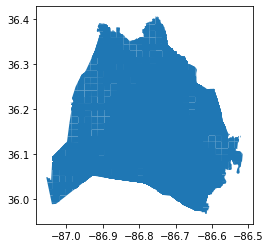

In [90]:
joined = joined2
joined2.plot()


In [87]:
# dax = dav_grids2.plot(figsize=(20, 20))
# joined2[joined2.row_num == 299].plot(ax = dax, figsize=(20, 20), color='red')

In [88]:
# dav_grids2["no_of_incidents"] = 0
# dav_grids2.head()

In [89]:
# dav_grids2["row_num"][299] == inc_index[0]
# inc_index

In [78]:
for i in range(len(inc_index)):
#     print(i)
    for j in range(joined.shape[0]):
#         print(j)
        if (joined["row_num"][j] == inc_index[i]):
            joined["no_of_incidents"][j]= inc_grids[i]
        
        

C:\Users\risha\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [163]:
joined

AttributeError: 'GeoDataFrame' object has no attribute 'timestamp_local'

<AxesSubplot:>

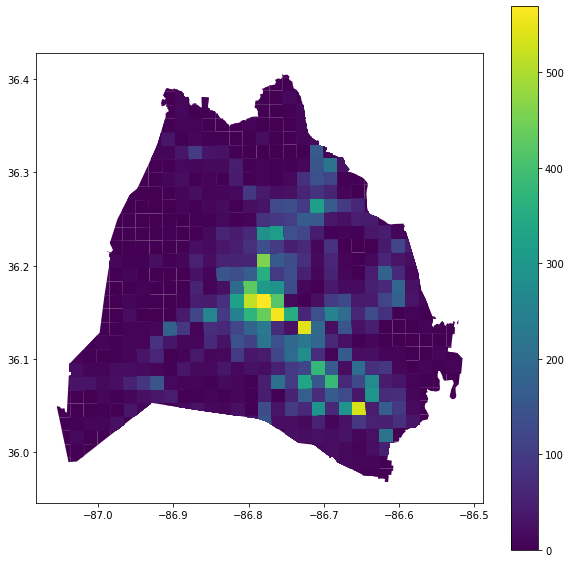

In [117]:
joined.plot(column='no_of_incidents', legend=True, figsize=(10, 10))

In [266]:
import math
start_time = 1483250400000 # 2017-01-01 00:00:00
end_time = 1614671157253 # 2021-03-02 01:45:57.253000
curr_time = start_time/1000
# print(start_time/1000)

incidents_per_month = [0 for i in range(int(math.ceil((end_time - start_time)/1000)/2592000)+1)]
incidents_per_day = [0 for i in range(int(math.ceil((end_time - start_time)/1000)/86400))]
incidents_per_4hrs = [0 for i in range(int(math.ceil((end_time - start_time)/1000)/14400))]
print(int(math.ceil((end_time - start_time)/1000)/14400))

9126


In [267]:
counter_4hrs = 0

for i in range(7, incidents.shape[0]):
    limit_time = curr_time +14400
    inc_time = (incidents.time_local[i])/1000
#     print(inc_time, limit_time, curr_time)
    if (inc_time < limit_time):
#         print("true")
        incidents_per_4hrs[counter_4hrs]+=1
    
    else:
        curr_time = limit_time
        counter_4hrs += 1
        
print(counter_4hrs)
print(incidents_per_4hrs)

 

9125
[4, 5, 1, 1, 2, 1, 4, 5, 3, 0, 2, 10, 6, 15, 5, 0, 1, 1, 5, 5, 3, 0, 0, 2, 1, 8, 0, 0, 6, 31, 12, 5, 5, 0, 0, 0, 0, 5, 1, 0, 0, 0, 1, 6, 1, 0, 0, 2, 3, 8, 0, 0, 0, 4, 0, 7, 5, 4, 6, 3, 0, 5, 3, 0, 7, 1, 9, 5, 3, 0, 0, 3, 4, 3, 1, 2, 1, 0, 1, 7, 3, 3, 2, 1, 2, 7, 3, 0, 1, 1, 11, 5, 3, 1, 5, 4, 2, 10, 6, 1, 1, 6, 2, 1, 1, 0, 5, 5, 10, 8, 5, 0, 0, 4, 4, 8, 1, 0, 0, 3, 4, 4, 6, 5, 2, 3, 2, 4, 2, 1, 0, 0, 0, 7, 1, 0, 0, 0, 4, 4, 0, 0, 1, 0, 0, 6, 1, 0, 0, 2, 2, 3, 3, 1, 3, 5, 5, 11, 6, 0, 1, 3, 2, 0, 3, 0, 0, 1, 1, 5, 2, 0, 3, 2, 2, 6, 1, 0, 0, 6, 4, 5, 1, 0, 2, 1, 5, 8, 0, 0, 0, 2, 4, 4, 1, 0, 2, 2, 4, 5, 6, 3, 0, 2, 6, 5, 0, 2, 1, 3, 3, 1, 1, 2, 2, 6, 1, 1, 0, 0, 3, 3, 4, 4, 4, 0, 1, 2, 3, 3, 1, 0, 2, 7, 5, 7, 1, 0, 3, 6, 4, 8, 3, 2, 0, 0, 2, 4, 1, 3, 0, 0, 0, 1, 1, 0, 1, 1, 5, 4, 0, 0, 0, 3, 5, 9, 4, 1, 0, 5, 5, 6, 7, 0, 0, 2, 4, 6, 0, 0, 5, 6, 4, 9, 4, 0, 1, 6, 5, 3, 1, 4, 1, 3, 2, 3, 2, 0, 0, 2, 1, 4, 1, 0, 2, 2, 4, 10, 2, 3, 4, 3, 3, 6, 0, 0, 3, 0, 1, 4, 3, 1, 2, 5, 5, 6, 4, 6, 0

In [269]:
sum_day = incidents_per_4hrs[0]
counter_day = 0
for i in range(1, counter_4hrs+1): 
    if i%6 == 0:
        incidents_per_day[counter_day] = sum_day
        counter_day+=1
        sum_day = 0
    sum_day += incidents_per_4hrs[i]
    
print(incidents_per_day)

[14, 24, 28, 15, 46, 22, 6, 10, 15, 25, 16, 20, 11, 17, 14, 29, 26, 14, 27, 16, 24, 9, 8, 9, 9, 17, 26, 6, 13, 15, 13, 15, 13, 20, 17, 15, 8, 15, 16, 22, 17, 10, 4, 12, 24, 20, 21, 24, 17, 9, 10, 26, 12, 16, 23, 18, 13, 21, 20, 24, 29, 25, 18, 13, 31, 31, 18, 14, 17, 14, 20, 24, 10, 13, 24, 29, 19, 20, 11, 20, 23, 4, 16, 13, 15, 22, 14, 13, 9, 20, 18, 13, 21, 28, 12, 13, 28, 16, 18, 16, 26, 20, 21, 22, 14, 11, 22, 30, 21, 20, 39, 24, 20, 18, 22, 18, 16, 28, 32, 19, 15, 26, 21, 29, 32, 18, 18, 19, 31, 10, 11, 22, 19, 25, 17, 24, 11, 29, 28, 24, 6, 25, 12, 13, 21, 38, 24, 10, 9, 15, 23, 13, 18, 13, 27, 28, 16, 18, 11, 39, 11, 14, 21, 28, 23, 16, 23, 20, 10, 12, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [271]:
sum_month = incidents_per_day[0]
counter_month = 0
for i in range(1, counter_day+1): 
    if i%30 == 0:
#         print(counter_month)
        incidents_per_month[counter_month] = sum_month
        counter_month+=1
        sum_year = 0
#         print(counter_year)
    sum_month += incidents_per_day[i]
print(incidents_per_month)

[531, 1026, 1575, 2201, 2803, 3188, 3188, 3188, 3188, 3188, 3188, 3188, 3188, 3188, 3188, 3188, 3188, 3188, 3188, 3188, 3188, 3188, 3240, 3715, 4130, 4716, 5382, 6208, 6928, 7666, 8387, 9136, 9905, 10729, 11582, 12366, 12999, 13700, 14395, 14765, 15172, 15735, 16321, 16934, 17551, 18142, 18748, 19315, 19862, 20341, 0]
